In [1]:
# set up
import pandas as pd
import numpy as np
from collections import defaultdict

# models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
# nlp
import nltk
from nltk.tokenize import word_tokenize # nltk tokenizer
nltk_stopwords = nltk.corpus.stopwords.words('english') # nltk stop words
from nltk.util import ngrams
# sys
import warnings
warnings.filterwarnings('ignore')
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# Overview
cluster reviewers based on their review text, and gain the insights from each cluster to understand the perception of price, quality, and value for each product for each cluster of customers.

# Data Preprocessing

In [14]:
# read from pickle stored from previous preprocessing work
df = pd.read_pickle("df_all.pkl")

In [15]:
df.shape

(512821, 25)

In [16]:
df = df.dropna(how = 'all',subset = ["Sound Bite Text"]) # drop rows with review text missing

In [17]:
df.shape

(512784, 25)

In [18]:
# drop rows with review text deleted
df.drop(df[(df["Sound Bite Text"] == "Post deleted by the author.")].index, inplace = True)

In [19]:
df.shape

(321344, 25)

In [11]:
# resample the data using stratification on the product class
from sklearn.utils import resample
df_new = resample(df, n_samples = 2000, replace=False, random_state=0)

# df_stratified = df.loc[products_new.index]

In [12]:
len(df_new)

2000

# Clustering

## Choose the optimal k
Hypothesis: from previous EDA for titles we know that topics are mostly around the products, and we know that there are three products: Samsung Galaxy, Iphone x, Iphone 8. There are three dimensions that reviewers care about ```price, quality, and value```.  So based on these two assumptions the clusters should be 6 to 9.

In [13]:
# test the k clusters on the subset
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_new["Sound Bite Text"])

In [14]:
# find out the optimal clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=1)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

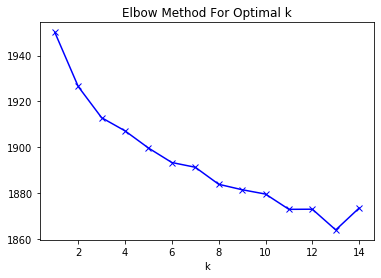

In [15]:
# plot the sum of squared distances
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.title('Elbow Method For Optimal k')
plt.show()

The plot confirms with our previous assumption that the optimal k lies between 6 and 9 as the marginal decrement of the sum squared distance slows down at this point. So let's set k = 6. 

## kmeans clustering to cluster review text

In [16]:
# pipiline
text_cluster = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                      ('tfidf', TfidfTransformer()),
                      ('km', KMeans(n_clusters = 6, init='k-means++', max_iter=1000, n_init=1))])

In [17]:
text_cluster.fit(df_new["Sound Bite Text"])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('km',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=1000, n_clusters=6, n_init=1, n_jobs=None,


In [64]:
# vectorize data with tf-idf transformer
documents = df["Sound Bite Text"]
# vector transform and remvoe stop words
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

In [60]:
# save to pickle
from sklearn.externals import joblib
# dump to pickle
joblib.dump(X, 'x_vector.pkl')
joblib.dump(vectorizer, 'vector.pkl')

['vector.pkl']

In [61]:
# load from pickel
X = joblib.load('x_vector.pkl')
vectorizer = joblib.load('vector.pkl')

In [62]:
X.shape

(321344, 267090)

In [84]:
# train model and choose k, load from trained model to reuse and save time
# true_k = 8
# model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
# model.fit(X)
# %time

In [8]:
from sklearn.externals import joblib

# dump to pickle
# joblib.dump(model, 'model.pkl')

# and reload from pickle
model = joblib.load('model.pkl')

In [9]:
np.array(model.cluster_centers_[:,0])

array([0.00116316, 0.00011493, 0.0015262 , 0.00111302, 0.00079859,
       0.00475465])

In [10]:
np.array(model.cluster_centers_[:,1])

array([0.00407308, 0.00087365, 0.00416428, 0.00196674, 0.00314529,
       0.00756819])

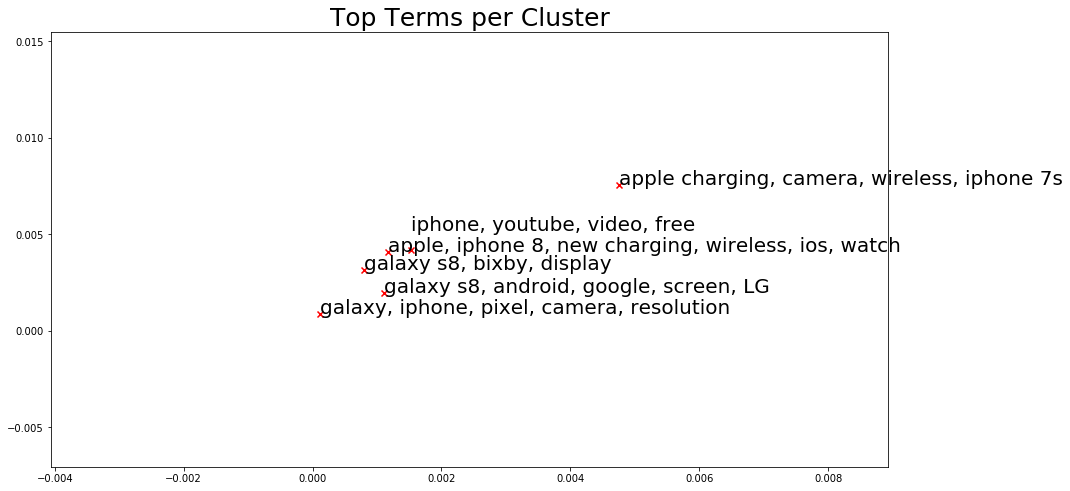

In [11]:
plt.figure(figsize = (15,8))
centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
plt.title("Top Terms per Cluster", fontsize = 25)

plt.text(0.00116316, 0.00407308, "apple, iphone 8, new charging, wireless, ios, watch",fontsize = 20)
plt.text(0.00011493, 0.00087365, r"galaxy, iphone, pixel, camera, resolution",fontsize = 20)
plt.text(0.0015262, 0.00516428, r"iphone, youtube, video, free",fontsize = 20)
plt.text(0.00111302, 0.00196674, r"galaxy s8, android, google, screen, LG",fontsize = 20)
plt.text(0.00079859, 0.00314529, r"galaxy s8, bixby, display",fontsize = 20)
plt.text(0.00475465, 0.00756819, r"apple charging, camera, wireless, iphone 7s",fontsize = 20)

plt.show()

In [65]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

# create dict for clusters
from collections import defaultdict 
clusters = defaultdict(list)
for i in range(6):
    print("===========")
    print("Cluster %d:" % i)
    print("===========")
    for ind in order_centroids[i, : 10]:
        print(' %s' % terms[ind])
    for ind in order_centroids[i, : 25]:
        clusters[i].append(terms[ind])    
    

Top terms per cluster:
Cluster 0:
 apple
 iphone
 new
 plus
 charging
 watch
 wireless
 ios
 oled
 year
Cluster 1:
 twitter
 pic
 com
 rt
 https
 s8
 galaxy
 samsung
 iphone
 dlvr
Cluster 2:
 iphone
 plus
 apple
 new
 phone
 just
 like
 camera
 pixel
 iphone8
Cluster 3:
 s8
 galaxy
 samsung
 phone
 android
 new
 google
 http
 screen
 lg
Cluster 4:
 s8
 galaxy
 samsung
 bixby
 new
 phone
 plus
 note
 smartphone
 display
Cluster 5:
 iphone
 plus
 apple
 new
 charging
 7s
 camera
 buy
 wireless
 glass


The top 10 keywords from each clusters tell us certain features for the ```price, quality, and value``` dimensions for each product.

Cluster one: apple's iphone 8 plus's new charging, wireless, and ios, watch

Cluster two: twitter samsung, and iphone

Cluster three: iphone plus's camera and comparison to pixel

Cluster four: galaxy s8, android, google, screen, and comparison to LG

Cluster five: galaxy s8, bixby, display

Cluster six: apple's iphone's new charging, camera, wireless, and comparison to 7s.

In [89]:
model.labels_.shape

(321344,)

# What feature of each product each reviewer cluster cares about

In [20]:
df["clusters"] = model.labels_

In [13]:
df.drop(columns = ["Post Type", "Media Type", "Author ID", "Author Name","Quoted Post",'Quoted Author Name', 'Quoted Author Handle',
       'Total Engagements', 'Post Comments', 'Post Likes', 'Post Shares',
       'Product Name'], inplace = True)

In [21]:
a = df.groupby("clusters")

In [29]:
df.columns

Index(['Sound Bite Text', 'Title', 'Source Type', 'Post Type', 'Media Type',
       'Published Date (GMT-04:00) New York', 'Author Gender', 'Author Name',
       'Author ID', 'Country', 'No. of Followers/Daily Unique Visitors',
       'Professions', 'Interests', 'Positive Objects', 'Negative Objects',
       'Richness', 'Quoted Post', 'Quoted Author Name', 'Quoted Author Handle',
       'Total Engagements', 'Post Comments', 'Post Likes', 'Post Shares',
       'Product Name', 'Rating', 'clusters'],
      dtype='object')

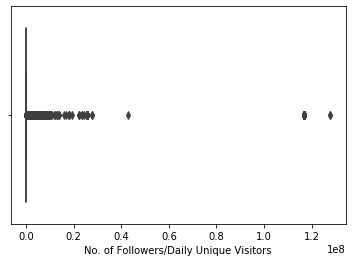

In [33]:
sns.boxplot(df['No. of Followers/Daily Unique Visitors'])

In [70]:
def userProfile(cluster):
    plt.figure(figsize = (15,5))
    sns.countplot(cluster['Country'], order = cluster['Country'].value_counts().index[:8])
    plt.title('Top 10 Countries of the Cluster')
    plt.show()

    sns.countplot(cluster['Author Gender'])
    plt.show()

    plt.figure(figsize = (10,5))
    sns.countplot(y = cluster['Professions'], order = cluster['Professions'].value_counts().index[:10])
    plt.title("User's Top 10 Professions")

    plt.figure(figsize = (10,5))
    sns.countplot(y = cluster['Interests'], order = cluster['Interests'].value_counts().index[:10])
    plt.title("User's Top 10 Interests")

## Cluster 1

In [22]:
cluster1 = a.get_group(0)

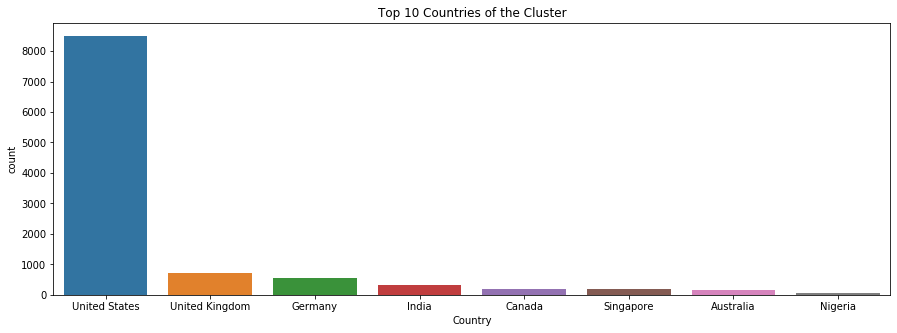

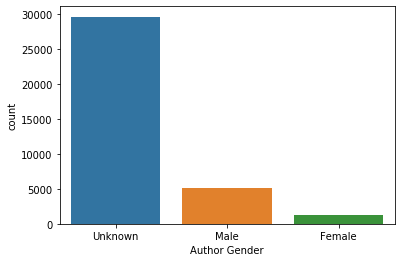

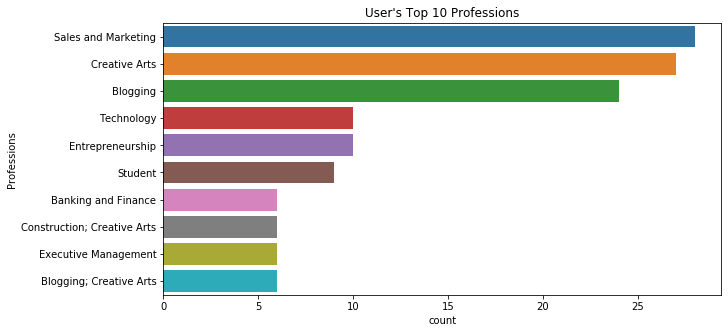

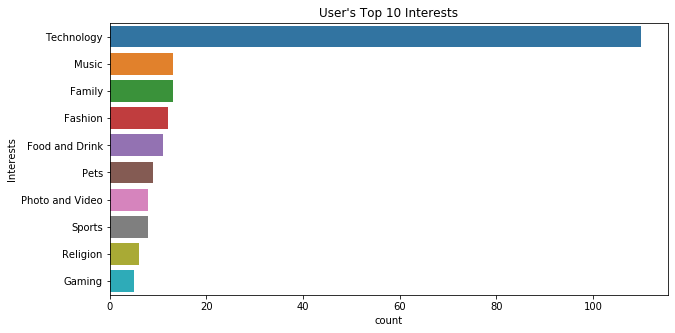

In [71]:
userProfile(cluster1)

In [29]:
no_1 = " ".join([i for i in list(cluster1["Negative Objects"].dropna())])
# tokenize and preprocess tokens
tokens_no1 = word_tokenize(no_1)
tokens_no1 = [token.lower() for token in tokens_no1 if token.isalpha()]
tokens_no1 = [token for token in tokens_no1 if token.isalpha()]
tokens_no1 = [token for token in tokens_no1 if token not in nltk_stopwords]

# to string
no1 = " ".join([i for i in tokens_no1])

In [30]:
len(tokens_no1)

11445

In [31]:
def countToken(token_list):
    dct = defaultdict(int)
    for token in token_list:
        if token not in dct:
            dct[token] = 1
        else:
            dct[token] += 1
    return dct

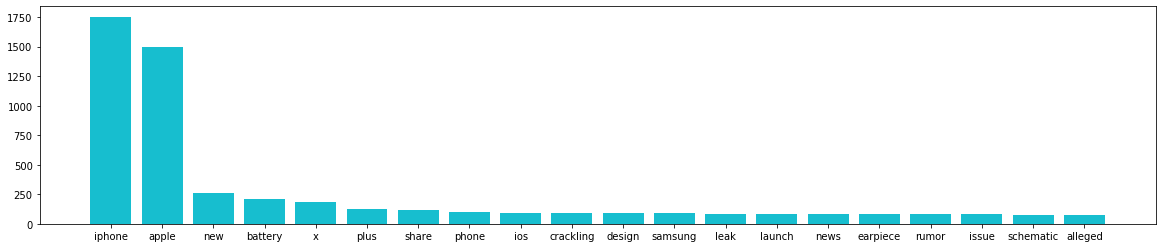

In [44]:
d = countToken(tokens_no1)
key = sorted(d, key = d.get, reverse = True)


# visualization
plt.figure(figsize = (20,4))
height = [d[k] for k in key][:20]
bars = key[:20]
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color=('tab:cyan'))
plt.xticks(y_pos, bars)
plt.show()



In [154]:
no1 = " ".join([i for i in tokens_no1])

In [155]:
no1 = no1.lower()

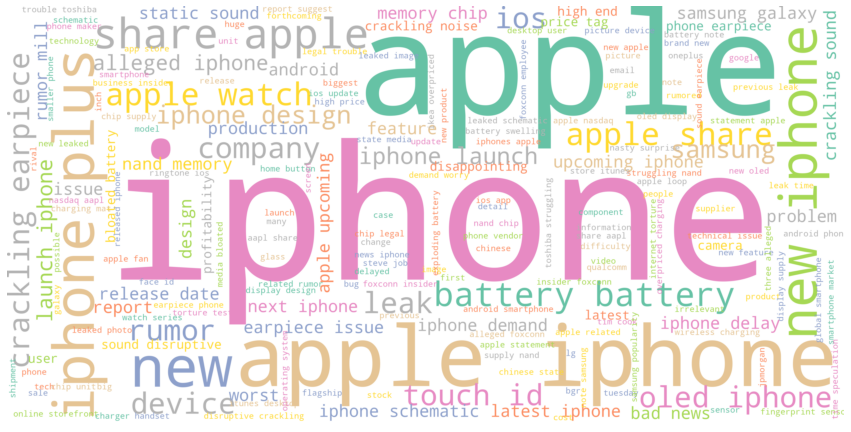

In [156]:
# Create the wordcloud object
wordcloud = WordCloud(width = 400, height = 200,margin = 0,
                      background_color = 'white', colormap = 'Set2',max_words=200000, scale = 10).generate(no1)
plt.figure(figsize = (15,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_cluster1.png")
plt.show()

In [45]:
po_1 = " ".join([i for i in list(cluster1["Positive Objects"].dropna())])
tokens_po_1 = word_tokenize(po_1)
tokens_po_1 = [token for token in tokens_po_1 if token.isalpha()]
tokens_po_1 = [token for token in tokens_po_1 if token not in nltk_stopwords]

po_1 = " ".join([i for i in tokens_po_1])
po_1 = po_1.lower()

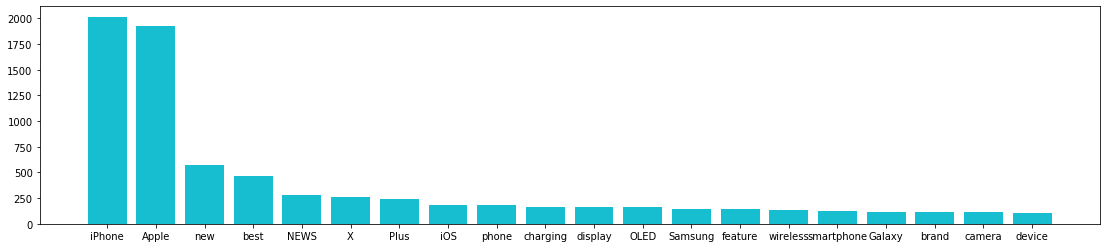

In [48]:
d = countToken(tokens_po_1)
key = sorted(d, key = d.get, reverse = True)


# visualization
plt.figure(figsize = (19,4))
height = [d[k] for k in key][:20]
bars = key[:20]
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color=('tab:cyan'))
plt.xticks(y_pos, bars)
plt.show()

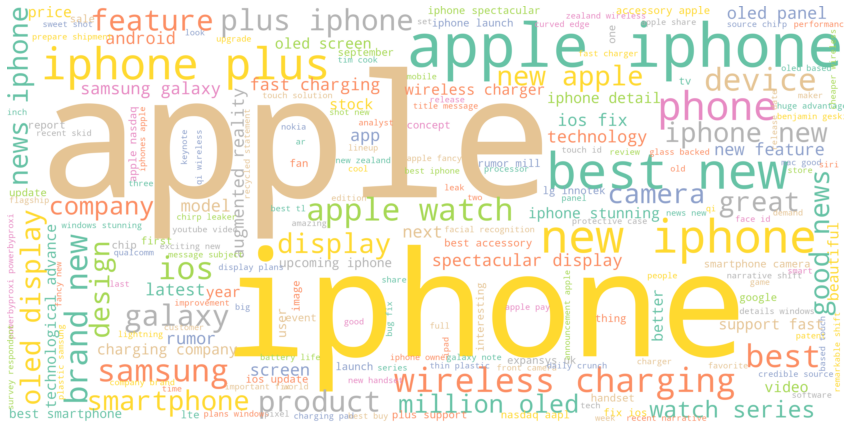

In [158]:
# Create the wordcloud object
wordcloud = WordCloud(width = 400, height = 200,margin = 0,
                      background_color = 'white', colormap = 'Set2',max_words=200000, scale = 10).generate(po_1)
plt.figure(figsize = (15,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_cluster1_po.png")
plt.show()

## Cluster 2

In [72]:
cluster2 = a.get_group(1)

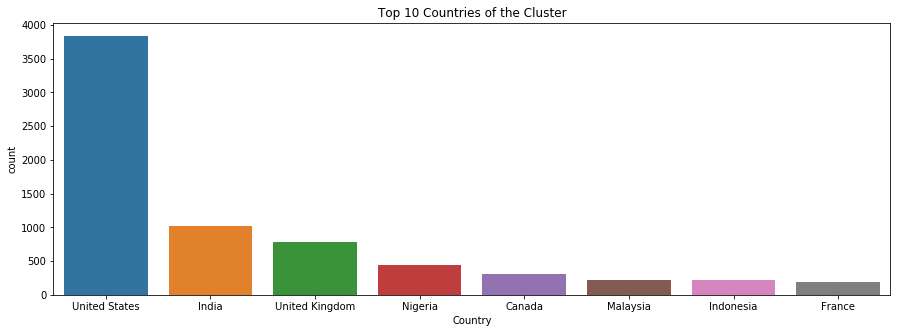

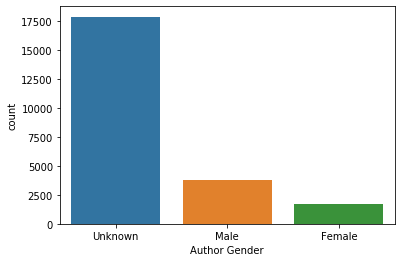

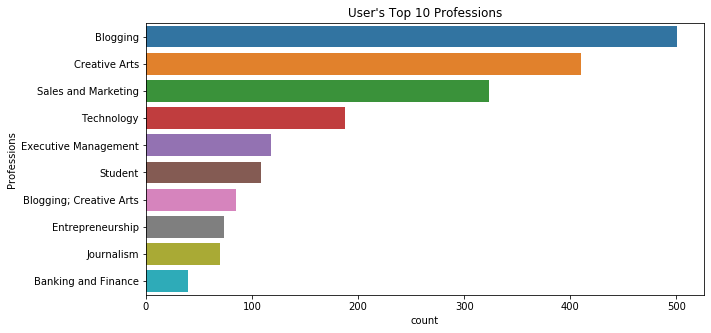

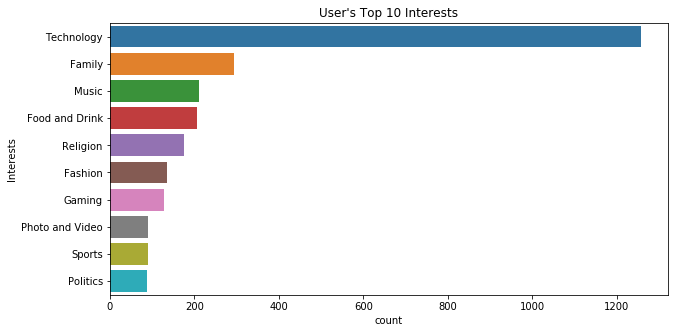

In [73]:
userProfile(cluster2)

In [53]:
no = " ".join([i for i in list(cluster2["Negative Objects"].dropna())])

In [54]:
po = " ".join([i for i in list(cluster2["Positive Objects"].dropna())])

### negative objects vs positive objects

In [49]:
def genToken(corpus):
    
    # preprocess str corpus into tokens
    tokens_no1 = word_tokenize(corpus)
    tokens_no1 = [token.lower() for token in tokens_no1 if token.isalpha()]
    tokens_no1 = [token for token in tokens_no1 if token.isalpha()]
    tokens_no1 = [token for token in tokens_no1 if token not in nltk_stopwords]

    # to string
    no1 = " ".join([i for i in tokens_no1])
    
    return tokens_no1, no1

In [56]:
no_token,no_str = genToken(no)

In [57]:
po_token,po_str = genToken(po)

In [59]:
def toBar(tokens):
    d = countToken(tokens)
    key = sorted(d, key = d.get, reverse = True)


    # visualization for top 20 key words
    plt.figure(figsize = (19,4))
    height = [d[k] for k in key][:20]
    bars = key[:20]
    y_pos = np.arange(len(bars))

    plt.bar(y_pos, height, color=('tab:cyan'))
    plt.xticks(y_pos, bars)
    plt.show()

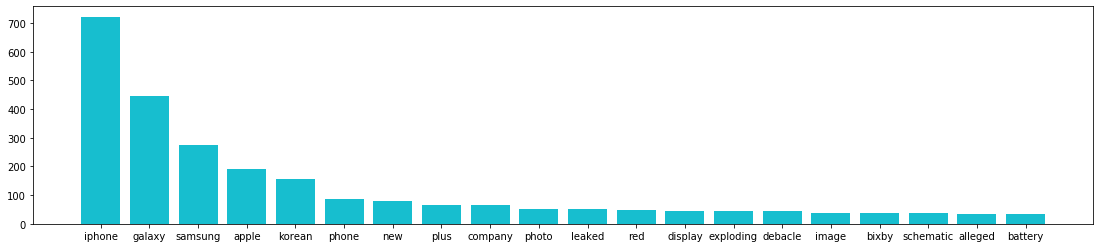

In [60]:
toBar(no_token)

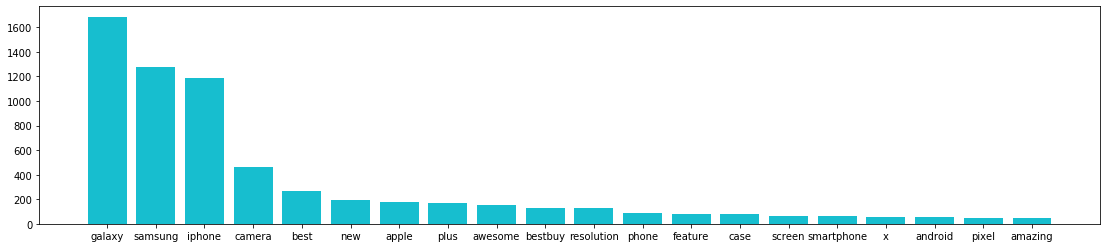

In [61]:
toBar(po_token)

In [62]:
def toCloud(cleanStr):
    # Create the wordcloud object
    wordcloud = WordCloud(width = 400, height = 200,margin = 0,
                          background_color = 'white', colormap = 'Set2',max_words=200000, scale = 10).generate(cleanStr)
    plt.figure(figsize = (15,30))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

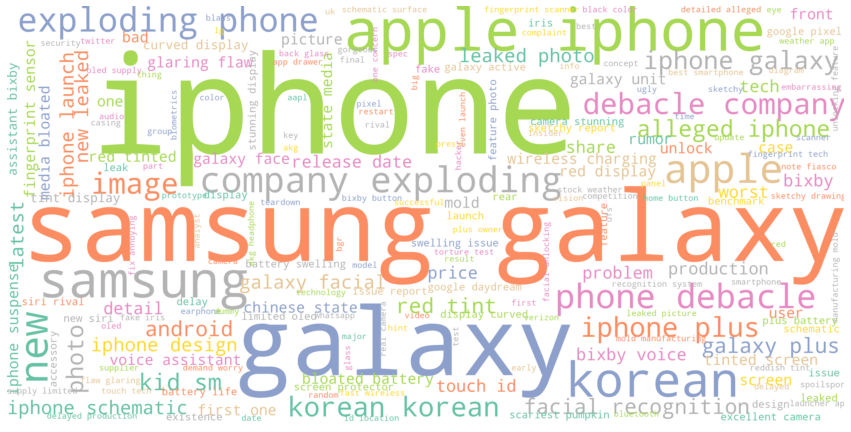

In [63]:
toCloud(no_str)

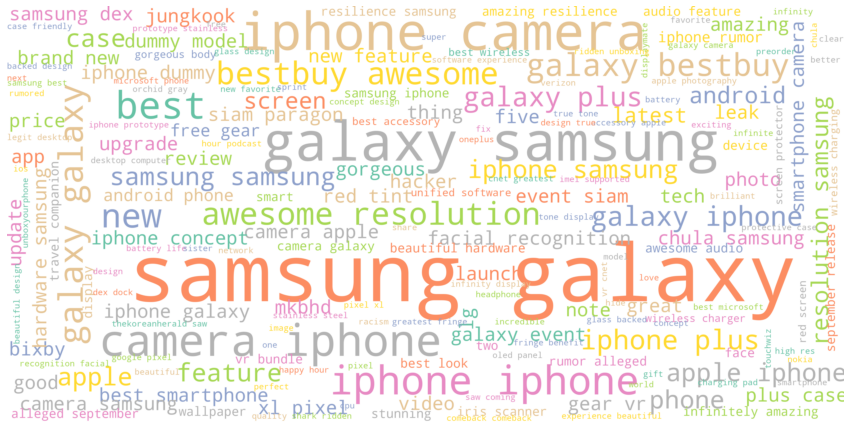

In [64]:
toCloud(po_str)

### Cluster 3

In [74]:
cluster3 = a.get_group(2)


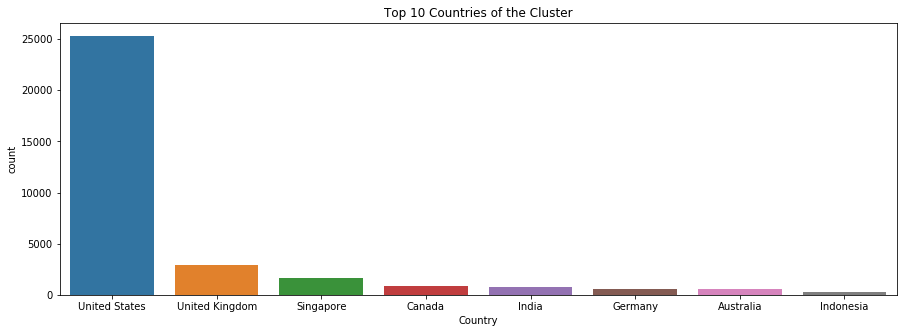

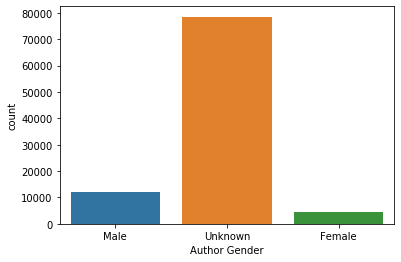

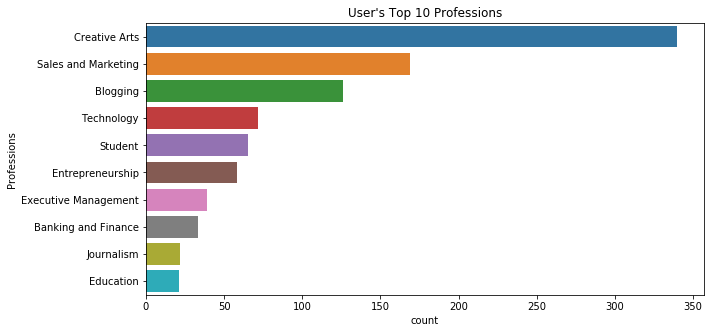

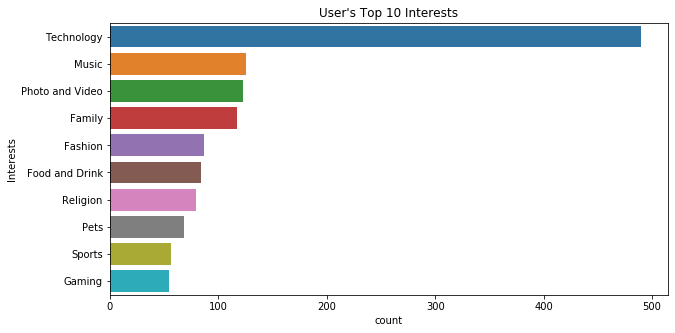

In [75]:
userProfile(cluster3)

In [65]:
no = " ".join([i for i in list(cluster3["Negative Objects"].dropna())])
po = " ".join([i for i in list(cluster3["Positive Objects"].dropna())])

In [66]:
no_token,no_str = genToken(no)
po_token,po_str = genToken(po)

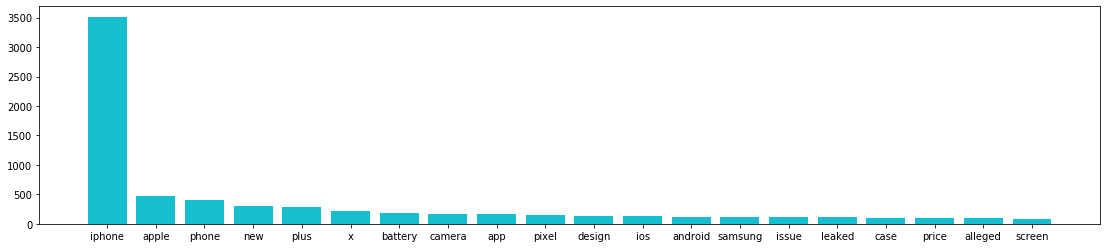

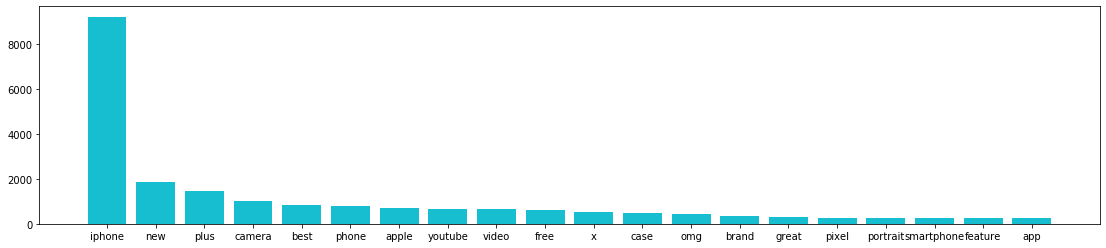

In [67]:
toBar(no_token)
toBar(po_token)

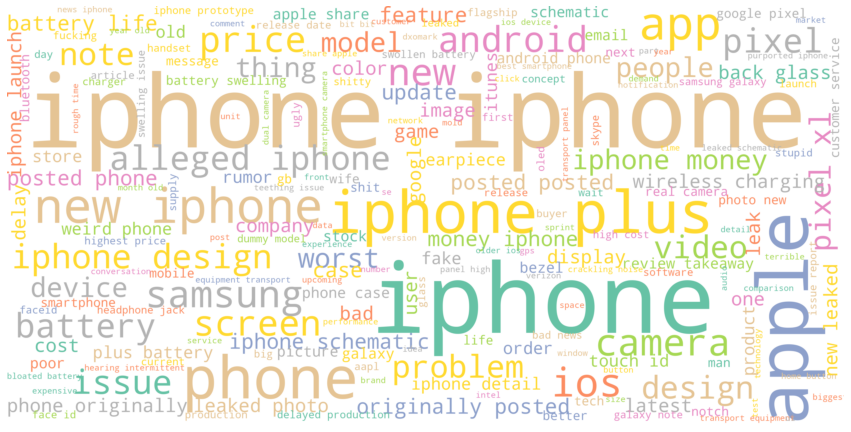

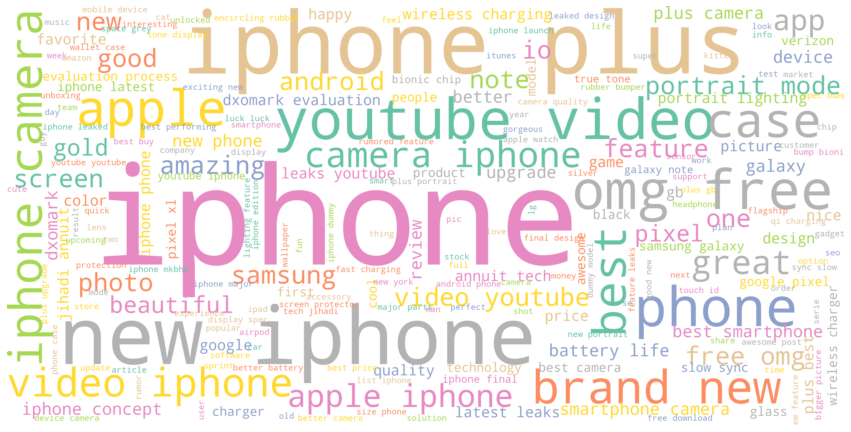

In [68]:
toCloud(no_str)
toCloud(po_str)


## Cluster 4

In [77]:
cluster4 = a.get_group(3)


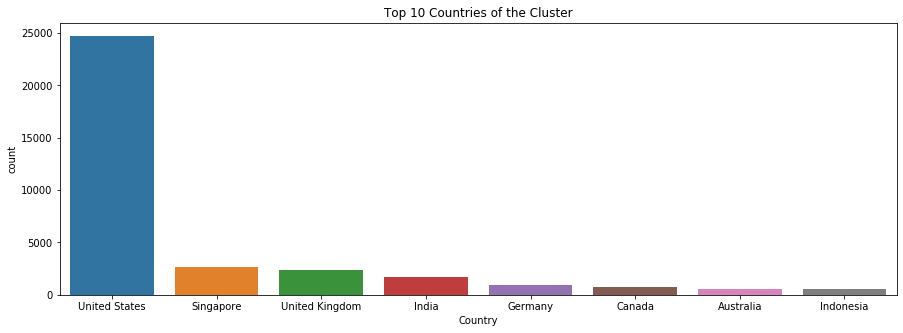

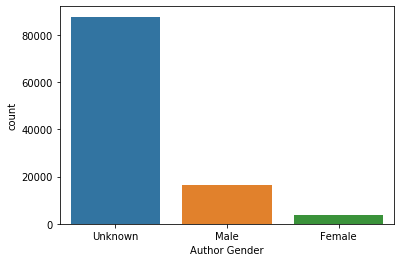

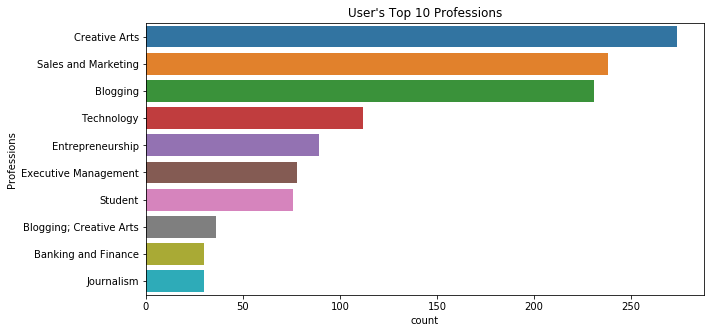

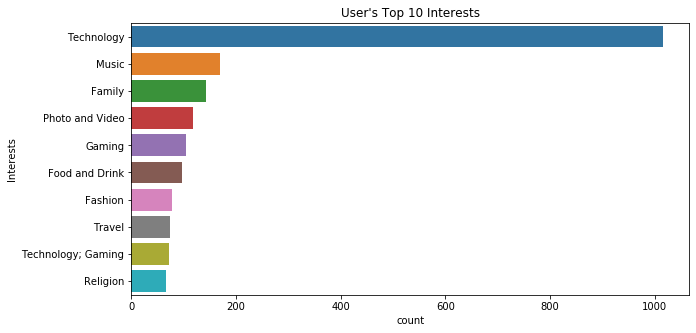

In [78]:
userProfile(cluster4)

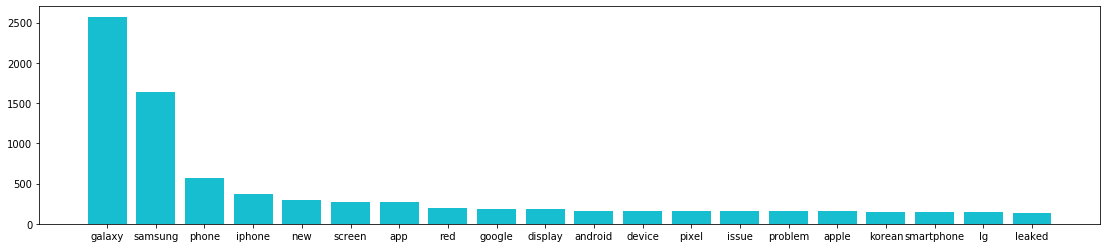

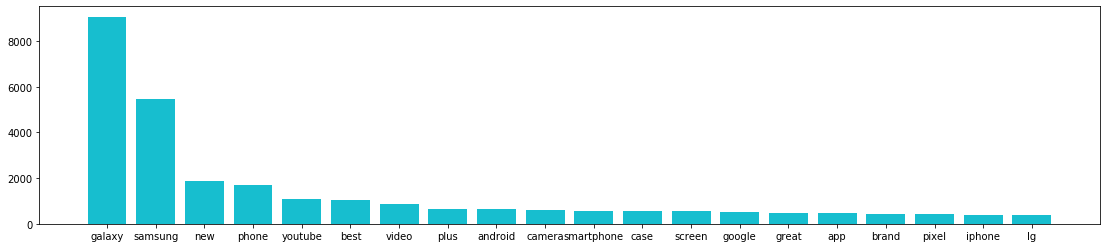

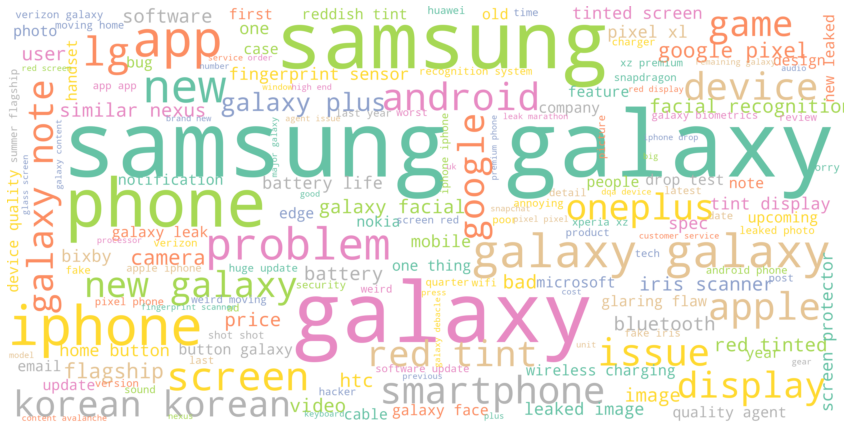

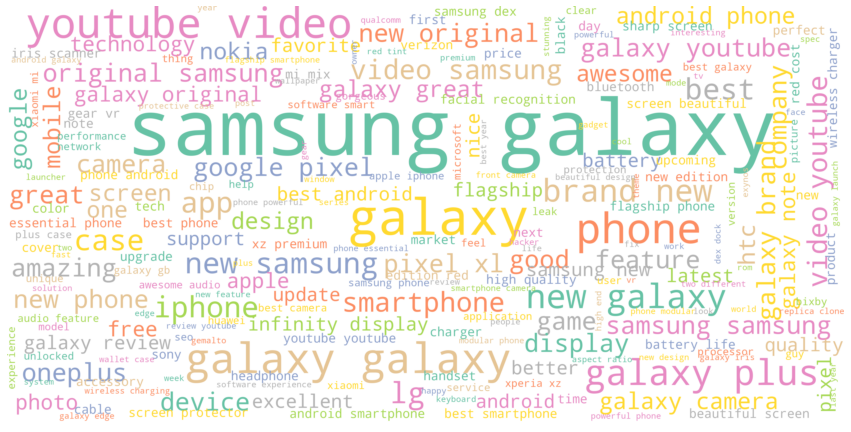

In [70]:
no = " ".join([i for i in list(cluster4["Negative Objects"].dropna())])
po = " ".join([i for i in list(cluster4["Positive Objects"].dropna())])

no_token,no_str = genToken(no)
po_token,po_str = genToken(po)

# to bar 
toBar(no_token)
toBar(po_token)

# to word cloud
toCloud(no_str)
toCloud(po_str)


## Cluster 5

In [79]:
cluster5 = a.get_group(4)


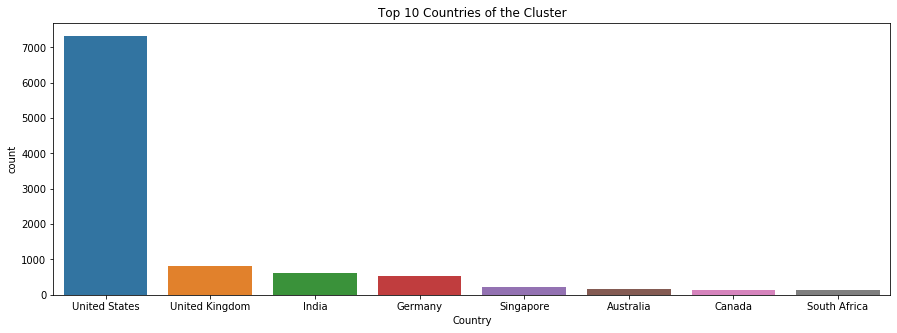

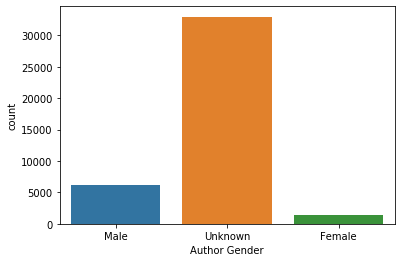

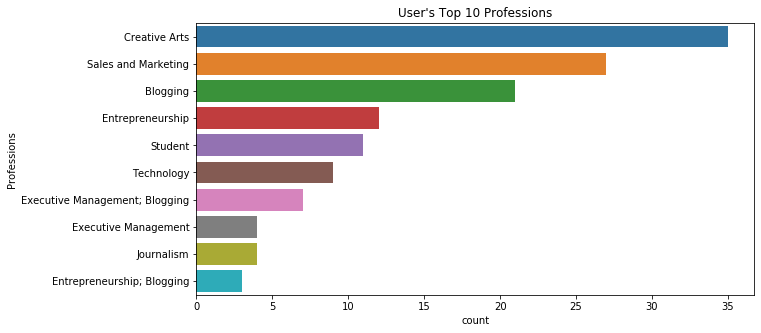

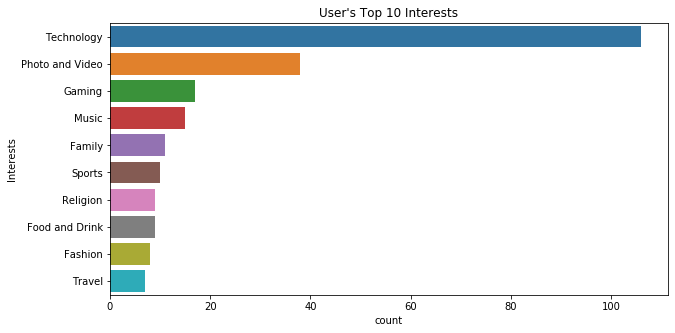

In [80]:
userProfile(cluster5)

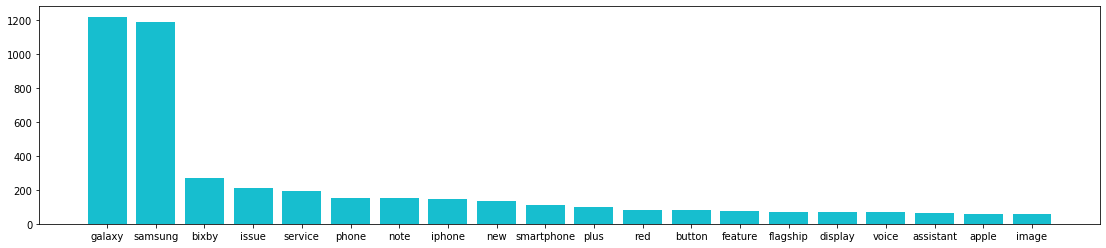

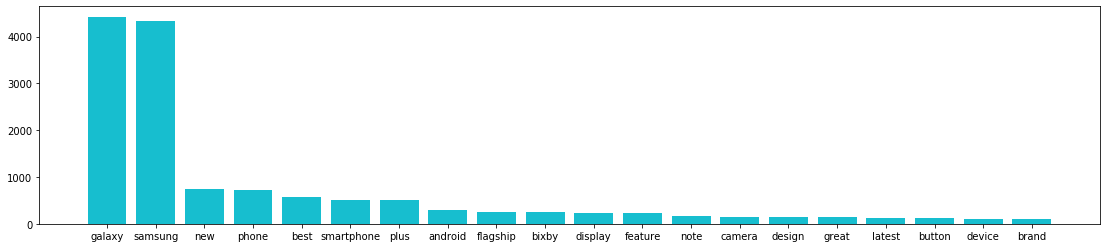

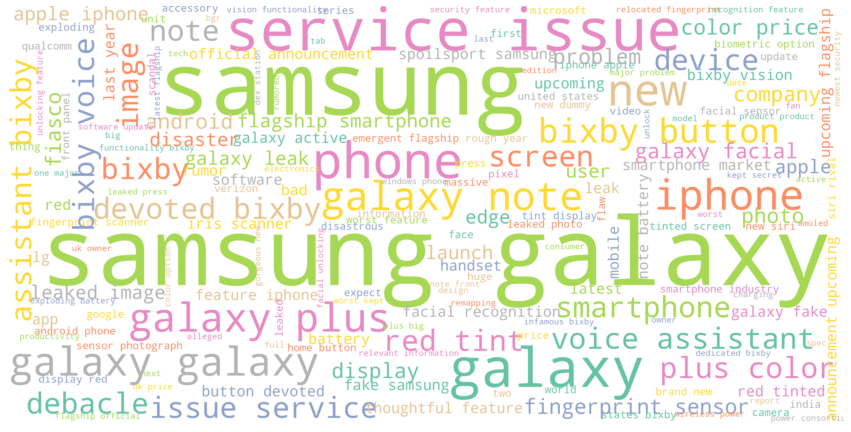

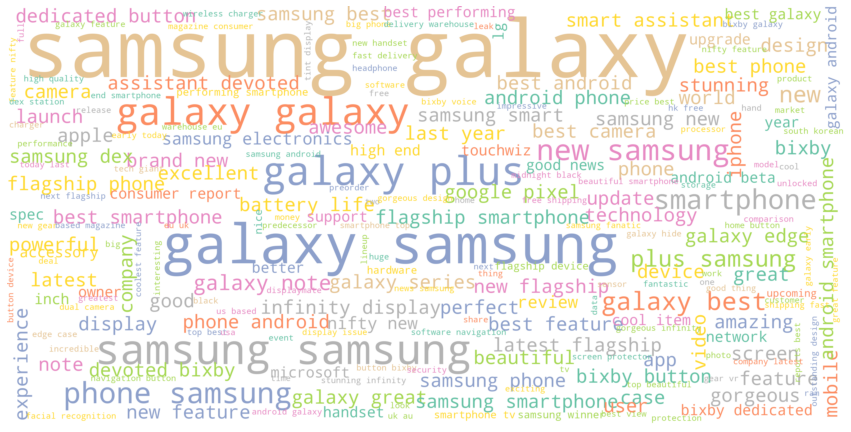

In [71]:
no = " ".join([i for i in list(cluster5["Negative Objects"].dropna())])
po = " ".join([i for i in list(cluster5["Positive Objects"].dropna())])

no_token,no_str = genToken(no)
po_token,po_str = genToken(po)

# to bar 
toBar(no_token)
toBar(po_token)

# to word cloud
toCloud(no_str)
toCloud(po_str)


## Cluster 6

In [81]:
cluster6 = a.get_group(5)


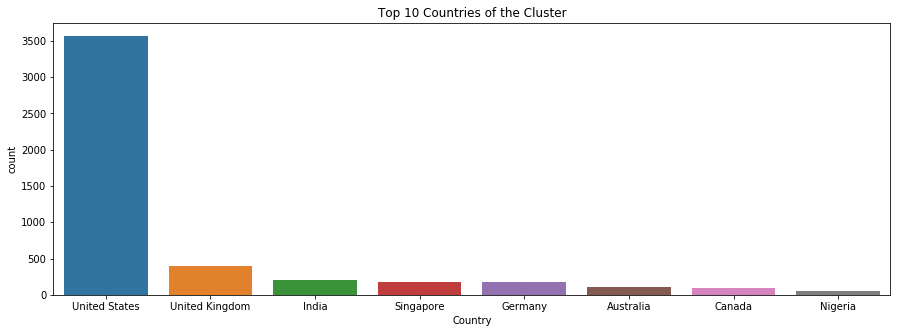

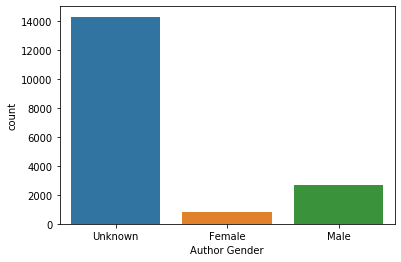

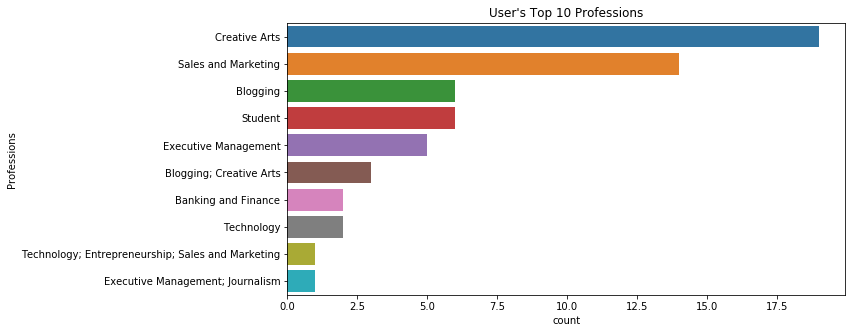

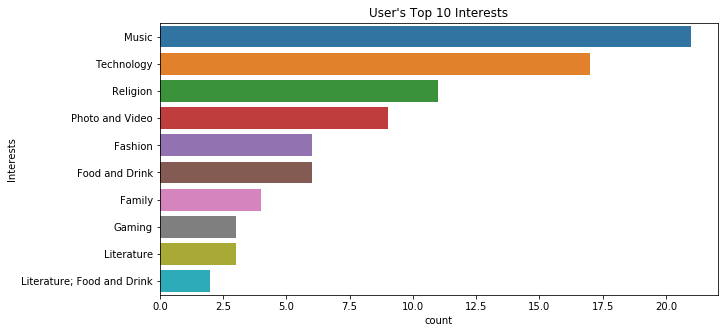

In [82]:
userProfile(cluster6)

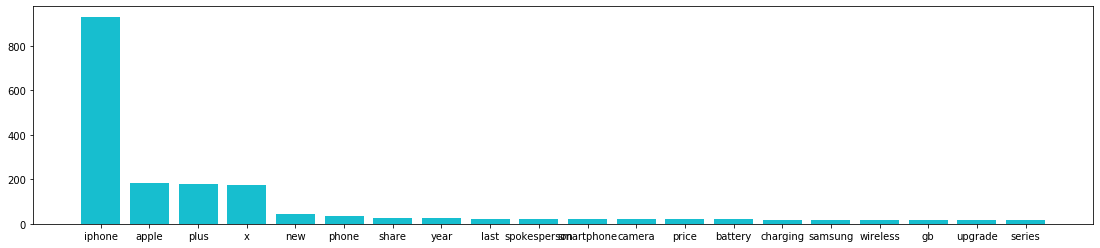

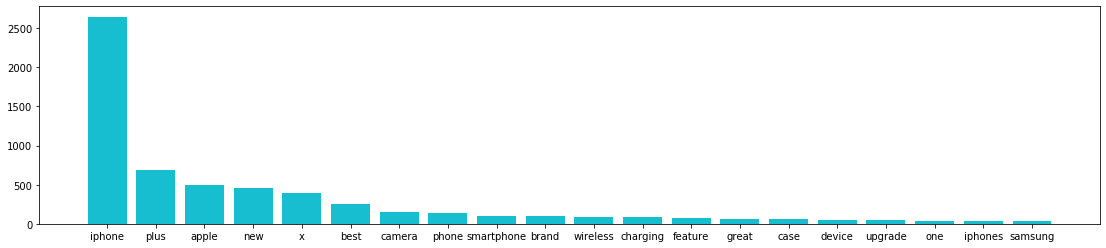

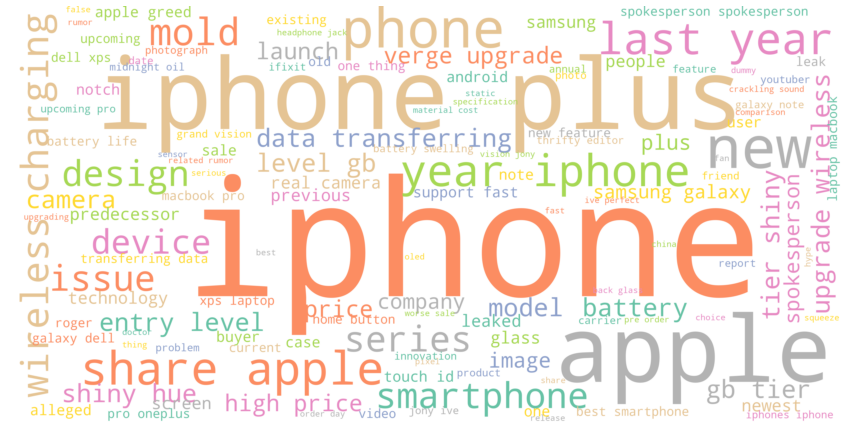

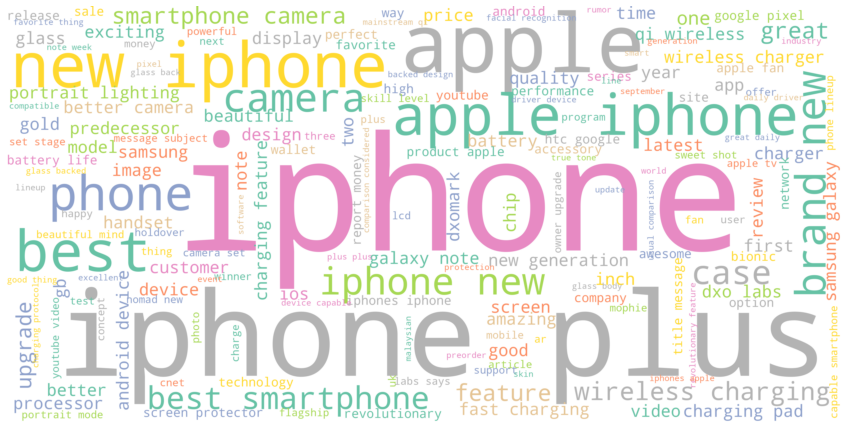

In [72]:
no = " ".join([i for i in list(cluster6["Negative Objects"].dropna())])
po = " ".join([i for i in list(cluster6["Positive Objects"].dropna())])

no_token,no_str = genToken(no)
po_token,po_str = genToken(po)

# to bar 
toBar(no_token)
toBar(po_token)

# to word cloud
toCloud(no_str)
toCloud(po_str)
